# Анализ: Ridge, Quantile regression и Polynomial regression

Данный ноутбук содержит три блока:
1. `blood.xlsx` — Ridge регрессия (поиск alpha с графиками, VIF, проверка значимости, сравнение с OLS).
2. `Kuiper.xls` — квантильная регрессия для разных tau, визуализация и сравнение с OLS/медианной регрессией.
3. `cigarettes.dat.txt` — полиномиальные модели (квадратичная, кубическая) и сравнение с линейной регрессией.

Все переменные и функции используют camelCase (например `dataFrame`, `fitModel`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.quantile_regression import QuantReg

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

plt.rcParams['figure.figsize'] = (8,5)
sns.set(style='whitegrid')


## 1. `blood.xlsx` — Ridge regression

Переменные: `X1` = систолическое давление (зависимая переменная), `X2` = возраст, `X3` = вес (lbs).
Задачи:
- Построить ridge для X1 ~ X2 + X3; найти оптимальный alpha (k) и показать графики, аналогичные `cv.plot` и `bias.plot`.
- Проверить мультиколлинеарность (VIF).
- Проверить значимость уравнения регрессии.
- Сравнить ridge с OLS (MSE, R², AIC для OLS).


In [2]:
bloodDf = pd.read_excel('../datasets/blood.xlsx')
display(bloodDf.head())
bloodDf = bloodDf.rename(columns=lambda s: s.strip())
yBlood = bloodDf['X1'].astype(float)
XBlood = bloodDf[['X2','X3']].astype(float)

,X1,X2,X3
0,132,52,173
1,143,59,184
2,153,67,194
3,162,73,211
4,154,64,196


### 1.2 Ridge — подбор alpha (k) и графики
Будем использовать `RidgeCV` для поиска alpha по кросс-валидации и построим два графика:
- `cv.plot`: средняя кросс-валидационная ошибка (MSE) vs alpha (log scale);
- `bias.plot`: поведение коэффициентов (и bias) vs alpha — покажем как меняются коэффициенты.

Best alpha (RidgeCV) = 0.7653919388230148


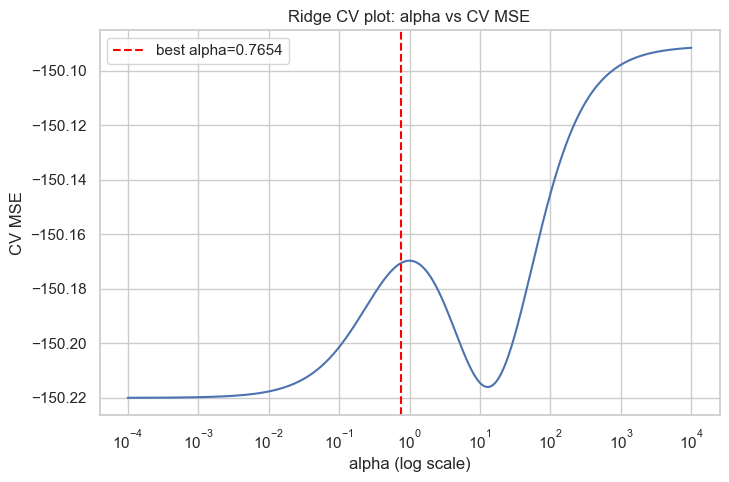

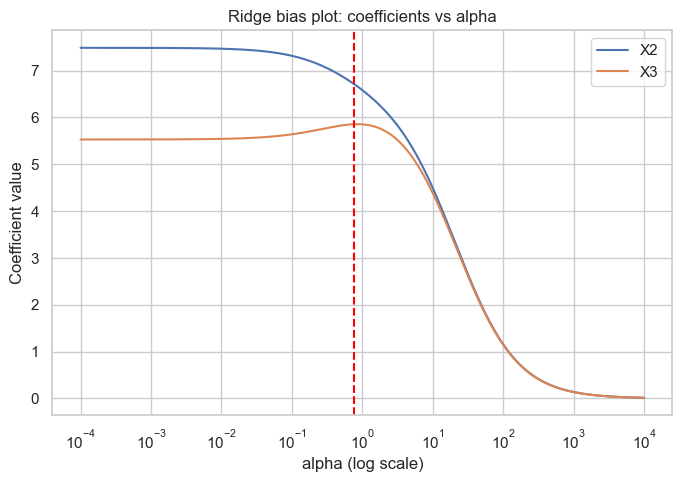

In [3]:
scalerBlood = StandardScaler()
XBloodScaled = scalerBlood.fit_transform(XBlood)

alphaGrid = np.logspace(-4, 4, 1000)
ridgeCv = RidgeCV(alphas=alphaGrid, scoring='neg_mean_squared_error', store_cv_results=True)
ridgeCv.fit(XBloodScaled, yBlood)
bestAlpha = ridgeCv.alpha_
print('Best alpha (RidgeCV) =', bestAlpha)


# cv.plot: MSE vs alpha
meanMsePerAlpha = -np.mean(ridgeCv.cv_results_, axis=0)
plt.figure()
plt.semilogx(alphaGrid, meanMsePerAlpha)
plt.axvline(bestAlpha, color='red', linestyle='--', label=f'best alpha={bestAlpha:.4g}')
plt.xlabel('alpha (log scale)')
plt.ylabel('CV MSE')
plt.title('Ridge CV plot: alpha vs CV MSE')
plt.legend()
plt.show()

# bias.plot: коэффициенты vs alpha
coefsPerAlpha = []
for a in alphaGrid:
    ridgeTemp = Ridge(alpha=a)
    ridgeTemp.fit(XBloodScaled, yBlood)
    coefsPerAlpha.append(ridgeTemp.coef_)
coefsPerAlpha = np.array(coefsPerAlpha)

plt.figure()
for j, name in enumerate(XBlood.columns):
    plt.semilogx(alphaGrid, coefsPerAlpha[:, j], label=name)
plt.axvline(bestAlpha, color='red', linestyle='--')
plt.xlabel('alpha (log scale)')
plt.ylabel('Coefficient value')
plt.title('Ridge bias plot: coefficients vs alpha')
plt.legend()
plt.show()


### 1.3 Итоговая Ridge-модель и сравнение с OLS
Построим Ridge с лучшим alpha и OLS; сравним MSE, R² и — для OLS — AIC. Также оценим значимость модели: для OLS используем F-test; для Ridge применим permutation test (оценка значимости модели через перестановки).

In [4]:
# Fit best Ridge
ridgeBest = Ridge(alpha=bestAlpha)
ridgeBest.fit(XBloodScaled, yBlood)
yPredRidge = ridgeBest.predict(XBloodScaled)
mseRidge = mean_squared_error(yBlood, yPredRidge)
r2Ridge = r2_score(yBlood, yPredRidge)

# Fit OLS via statsmodels to get summary and F-test
XBloodWithConst = sm.add_constant(XBlood)
olsModel = sm.OLS(yBlood, XBloodWithConst).fit()
yPredOls = olsModel.fittedvalues
mseOls = mean_squared_error(yBlood, yPredOls)
r2Ols = olsModel.rsquared

print('Ridge (alpha=%.6g): MSE=%.4f, R2=%.4f' % (bestAlpha, mseRidge, r2Ridge))
print('OLS: MSE=%.4f, R2=%.4f, AIC=%.4f' % (mseOls, r2Ols, olsModel.aic))
print('\nOLS summary:')
print(olsModel.summary())


Ridge (alpha=0.765392): MSE=4.1376, R2=0.9755
OLS: MSE=3.9084, R2=0.9768, AIC=52.2112

OLS summary:
                            OLS Regression Results                            
Dep. Variable:                     X1   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     168.8
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           2.87e-07
Time:                        23:20:57   Log-Likelihood:                -23.106
No. Observations:                  11   AIC:                             52.21
Df Residuals:                       8   BIC:                             53.40
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

c:\Python\lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [5]:
# Проверка значимости Ridge-модели через permutation test (R^2 на исходных данных vs случайные перемешивания y)
def permutationTestModelR2(Xmat, yvec, fitFunc, scoreFunc, nPerm=500, randomState=42):
    rng = np.random.RandomState(randomState)
    # fit on original
    model = fitFunc()
    model.fit(Xmat, yvec)
    scoreOrig = scoreFunc(model, Xmat, yvec)
    permScores = []
    for i in range(nPerm):
        yPerm = rng.permutation(yvec)
        modelPerm = fitFunc()
        modelPerm.fit(Xmat, yPerm)
        permScores.append(scoreFunc(modelPerm, Xmat, yPerm))
    permScores = np.array(permScores)
    pValue = (permScores >= scoreOrig).sum() / float(nPerm)
    return scoreOrig, permScores, pValue

def ridgeFitFactory(alpha=bestAlpha):
    return lambda: Ridge(alpha=alpha)

def r2ScoreFunc(model, Xmat, yvec):
    ypred = model.predict(Xmat)
    return r2_score(yvec, ypred)

scoreOrigRidge, permScoresRidge, pValRidge = permutationTestModelR2(XBloodScaled, yBlood, lambda: Ridge(alpha=bestAlpha), r2ScoreFunc, nPerm=500)
print('Ridge permutation test: observed R2=%.4f, permutation p-value=%.4f' % (scoreOrigRidge, pValRidge))

Ridge permutation test: observed R2=0.9755, permutation p-value=0.0000


### 1.4 Мультиколлинеарность (VIF)
Вычислим VIF для предикторов X2, X3.

In [6]:
vifDf = pd.DataFrame()
vifDf['feature'] = XBlood.columns
vifDf['VIF'] = [variance_inflation_factor(XBlood.values, i) for i in range(XBlood.shape[1])]
display(vifDf)

,feature,VIF
0,X2,241.333801
1,X3,241.333801


## 2. `Kuiper.xls` — Квантильная регрессия и сравнение с OLS

Переменные: `Price` (зависимая), `Mileage, Liter, Cruise, Sound, Leather` — предикторы.
Задачи:
- Построить квантильную регрессию для нескольких tau (например, 0.1, 0.25, 0.5, 0.75, 0.9).
- Изобразить коэффициенты vs tau и несколько прогнозных линий/эффектов.
- Построить OLS и сравнить с медианной регрессией (tau=0.5).


In [7]:
kuiperDf = pd.read_excel('../datasets/Kuiper.xls')
display(kuiperDf.head())

def toFloatFromCommaSafe(x):
    try:
        if pd.isna(x):
            return np.nan
        return float(str(x).strip().replace(',', '.'))
    except:
        return np.nan

numColsKuiper = ['Price','Mileage','Liter','Cruise','Sound','Leather']
for c in numColsKuiper:
    if c in kuiperDf.columns:
        kuiperDf[c] = kuiperDf[c].apply(toFloatFromCommaSafe)

kuiperDfClean = kuiperDf.dropna(subset=numColsKuiper).copy()
yKuiper = kuiperDfClean['Price']
XKuiper = kuiperDfClean[['Mileage','Liter','Cruise','Sound','Leather']]


,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


### 2.2 Квантильная регрессия для набора tau и визуализация коэффициентов


Quantile 0.1:
                         QuantReg Regression Results                          
Dep. Variable:                  Price   Pseudo R-squared:               0.3461
Model:                       QuantReg   Bandwidth:                       3594.
Method:                 Least Squares   Sparsity:                        9959.
Date:                Wed, 29 Oct 2025   No. Observations:                  804
Time:                        23:20:58   Df Residuals:                      798
                                        Df Model:                            5
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5805.9347    449.733     12.910      0.000    4923.135    6688.735
Mileage       -0.1107      0.014     -8.085      0.000      -0.138      -0.084
Liter       3505.4843     94.397     37.136      0.000    3320.189    3690.779
Cruise       446.5867    301.716      

C:\Users\Faste\AppData\Roaming\Python\Python310\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\Faste\AppData\Roaming\Python\Python310\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\Faste\AppData\Roaming\Python\Python310\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\Faste\AppData\Roaming\Python\Python310\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


,const,Mileage,Liter,Cruise,Sound,Leather
tau,,,,,,
0.10,5805.934688,-0.110668,3505.484330,446.586736,-312.269122,1062.660758
0.25,6808.018417,-0.116988,3726.891282,712.063421,-770.228072,510.097024
0.50,5474.893128,-0.104225,4417.177581,1564.410943,-1193.924948,1075.841368
0.75,10153.445468,-0.133349,2861.565386,13123.710552,-2487.648379,2950.512327
0.90,13368.381183,-0.202784,3337.103014,15510.072703,-2456.439843,1275.731119


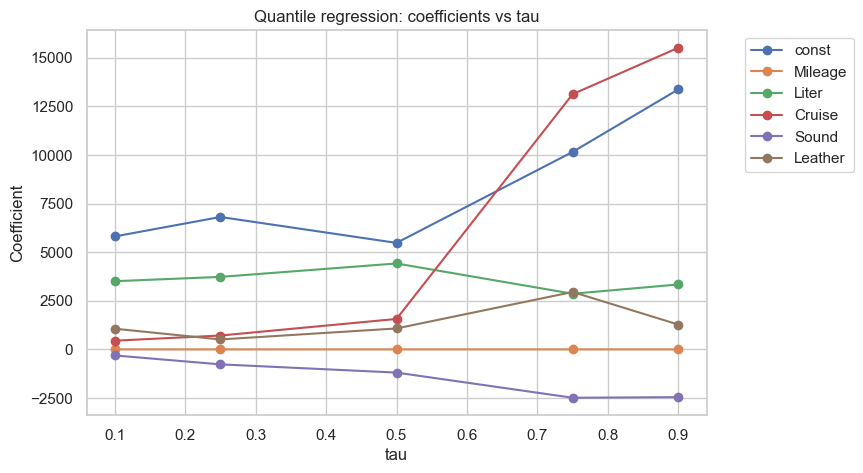

In [8]:
taus = [0.1, 0.25, 0.5, 0.75, 0.9]
coefResults = {}
XKuiperWithConst = sm.add_constant(XKuiper)
for tau in taus:
    qrModel = QuantReg(yKuiper, XKuiperWithConst).fit(q=tau)
    coefResults[tau] = qrModel.params
    print(f'Quantile {tau}:')
    print(qrModel.summary())

coefDf = pd.DataFrame(coefResults).T
coefDf.index.name = 'tau'
display(coefDf)

# Plot coefficients vs tau
plt.figure()
for col in coefDf.columns:
    plt.plot(coefDf.index, coefDf[col], marker='o', label=col)
plt.xlabel('tau')
plt.ylabel('Coefficient')
plt.title('Quantile regression: coefficients vs tau')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()


### 2.3 Сравнение OLS и медианной регрессии (tau=0.5)
Построим OLS и median (tau=0.5) и сравним прогнозы/ошибки (MSE, MAE).

In [9]:
olsKuiperModel = sm.OLS(yKuiper, XKuiperWithConst).fit()
print('OLS summary:')
print(olsKuiperModel.summary())

medianCoef = coefResults[0.5]
medianPred = XKuiperWithConst.dot(medianCoef)

olsPred = olsKuiperModel.fittedvalues

mseOls = mean_squared_error(yKuiper, olsPred)
mseMedian = mean_squared_error(yKuiper, medianPred)
maeOls = np.mean(np.abs(yKuiper - olsPred))
maeMedian = np.mean(np.abs(yKuiper - medianPred))

print('Comparison on full sample:')
print('OLS: MSE=%.4f, MAE=%.4f' % (mseOls, maeOls))
print('Median (tau=0.5): MSE=%.4f, MAE=%.4f' % (mseMedian, maeMedian))


OLS summary:
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     113.9
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           7.24e-91
Time:                        23:20:58   Log-Likelihood:                -8319.6
No. Observations:                 804   AIC:                         1.665e+04
Df Residuals:                     798   BIC:                         1.668e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7318.2667   1183.775      6

### 2.4 Визуализация: предсказанные квантильные линии для зависимости Price от Mileage (others at mean)


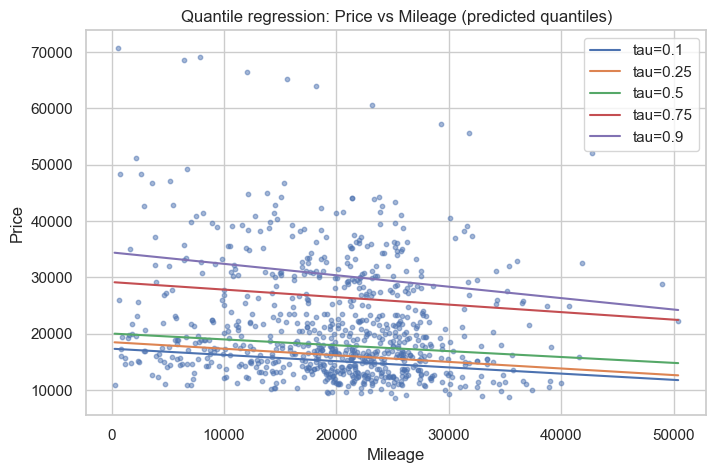

In [10]:
plt.figure()
xVar = 'Mileage'
xGrid = np.linspace(XKuiper[xVar].min(), XKuiper[xVar].max(), 100)
meanVals = XKuiper.mean()
for tau in taus:
    coefTau = coefResults[tau]
    dfGrid = pd.DataFrame({
        'const': 1.0,
        'Mileage': xGrid,
        'Liter': meanVals['Liter'],
        'Cruise': meanVals['Cruise'],
        'Sound': meanVals['Sound'],
        'Leather': meanVals['Leather']
    })
    yGrid = dfGrid.dot(coefTau)
    plt.plot(xGrid, yGrid, label=f'tau={tau}')

plt.scatter(XKuiper[xVar], yKuiper, s=10, alpha=0.5)
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.title('Quantile regression: Price vs Mileage (predicted quantiles)')
plt.legend()
plt.show()


## 3. `cigarettes.dat.txt` — нелинейные полиномиальные модели

Переменные: `carbon monoxide` (y), `tar`, `nicotine`, `weight` — x1,x2,x3.
Задачи:
- Построить полиномиальные модели степени 2 и 3 (включая кросс-термы) и OLS линейную модель.
- Сравнить модели по AIC, RMSE, R², и привести summary для каждой (через statsmodels OLS).


In [11]:
rows = []
with open('../datasets/cigarettes.dat.txt', 'r', encoding='utf-8') as fh:
    for line in fh:
        tokens = line.strip().split()
        if len(tokens) < 4:
            continue
        numeric = tokens[-4:]
        brand = ' '.join(tokens[:-4])
        try:
            carbonMonoxideVal = float(numeric[0].replace(',', '.'))
            tarVal = float(numeric[1].replace(',', '.'))
            nicotineVal = float(numeric[2].replace(',', '.'))
            weightVal = float(numeric[3].replace(',', '.'))
            rows.append((brand, carbonMonoxideVal, tarVal, nicotineVal, weightVal))
        except:
            continue
cigDf = pd.DataFrame(rows, columns=['brand','carbonMonoxide','tar','nicotine','weight'])
display(cigDf.head())
cigDf = cigDf.dropna()
yCig = cigDf['carbonMonoxide']
XCig = cigDf[['tar','nicotine','weight']]

,brand,carbonMonoxide,tar,nicotine,weight
0,Alpine,14.1,0.86,0.9853,13.6
1,Benson&Hedges,16.0,1.06,1.0938,16.6
2,BullDurham,29.8,2.03,1.1650,23.5
3,CamelLights,8.0,0.67,0.9280,10.2
4,Carlton,4.1,0.40,0.9462,5.4


### 3.2 Линейная модель (OLS)


In [12]:
XCigWithConst = sm.add_constant(XCig)
olsCigModel = sm.OLS(yCig, XCigWithConst).fit()
print('OLS Cigarettes summary:')
print(olsCigModel.summary())

OLS Cigarettes summary:
                            OLS Regression Results                            
Dep. Variable:         carbonMonoxide   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     258.3
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           9.95e-17
Time:                        23:20:58   Log-Likelihood:                -32.889
No. Observations:                  25   AIC:                             73.78
Df Residuals:                      21   BIC:                             78.65
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3696      2

### 3.3 Полиномиальные модели (квадрат и куб)
Построим design matrix с `PolynomialFeatures` и подгоним OLS через statsmodels, чтобы получить AIC и summary.

In [13]:
def fitPolynomialOls(Xdf, yvec, degree):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    Xpoly = poly.fit_transform(Xdf)
    featureNames = poly.get_feature_names_out(Xdf.columns)
    XpolyDf = pd.DataFrame(Xpoly, columns=featureNames)
    XpolyWithConst = sm.add_constant(XpolyDf)
    model = sm.OLS(yvec, XpolyWithConst).fit()
    return model, XpolyWithConst, featureNames

modelsCig = {}
for deg in [2,3]:
    modelDeg, designDeg, featNamesDeg = fitPolynomialOls(XCig, yCig, deg)
    modelsCig[deg] = (modelDeg, designDeg, featNamesDeg)
    print(f'Polynomial degree={deg} summary:')
    print(modelDeg.summary())


Polynomial degree=2 summary:
                            OLS Regression Results                            
Dep. Variable:         carbonMonoxide   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     90.93
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           1.90e-11
Time:                        23:20:58   Log-Likelihood:                -28.107
No. Observations:                  25   AIC:                             76.21
Df Residuals:                      15   BIC:                             88.40
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const        

### 3.4 Сравнение моделей (линейной, квадратичной, кубической)
Сравним по AIC, RMSE и R² (на обучающей выборке).

,aic,rmse,r2
model,,,
OLS_linear,73.778958,0.901803,0.973611
poly_2,76.213119,0.744773,0.982001
poly_3,61.677155,0.373292,0.995478


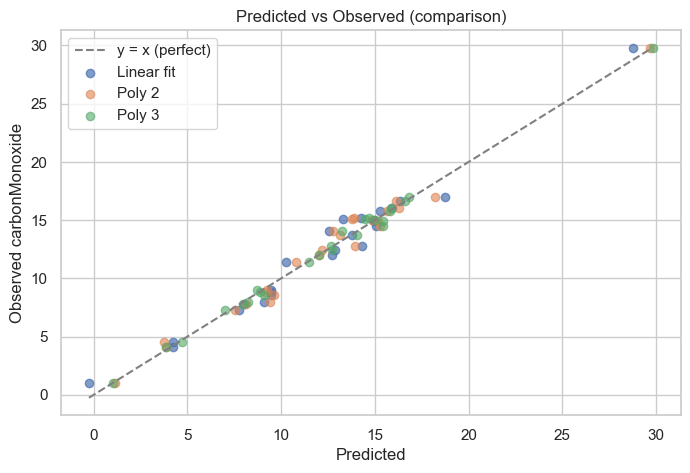

In [14]:
comparisonRows = []
comparisonRows.append({'model':'OLS_linear','aic':olsCigModel.aic,'rmse':np.sqrt(mean_squared_error(yCig, olsCigModel.fittedvalues)),'r2':olsCigModel.rsquared})
for deg, (modelDeg, designDeg, featNamesDeg) in modelsCig.items():
    comparisonRows.append({'model':f'poly_{deg}','aic':modelDeg.aic,'rmse':np.sqrt(mean_squared_error(yCig, modelDeg.fittedvalues)),'r2':modelDeg.rsquared})
comparisonDf = pd.DataFrame(comparisonRows).set_index('model')
display(comparisonDf)

plt.figure()
minVal = min(yCig.min(), olsCigModel.fittedvalues.min())
maxVal = max(yCig.max(), olsCigModel.fittedvalues.max())
plt.plot([minVal, maxVal], [minVal, maxVal], '--', color='gray', label='y = x (perfect)')

plt.scatter(olsCigModel.fittedvalues, yCig, label='Linear fit', alpha=0.7)
for deg, (modelDeg, _, _) in modelsCig.items():
    plt.scatter(modelDeg.fittedvalues, yCig, label=f'Poly {deg}', alpha=0.6)
plt.xlabel('Predicted')
plt.ylabel('Observed carbonMonoxide')
plt.legend()
plt.title('Predicted vs Observed (comparison)')
plt.show()
